In [137]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.3.


In [138]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence


In [139]:
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, r2_score, classification_report

import math

from rfpimp import *

from collections import defaultdict

In [140]:
file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/master_df_20191203.xlsx"
data = pd.read_excel(file)
df_master = pd.DataFrame(data).set_index('FIPS')

In [141]:
print(df_master.columns)

Index(['PropSFHA', 'AveDepth', 'PropDG', 'MaxDepth', 'AveLS', 'HurTrack',
       'PeakGust', 'MaxSusta', 'SpecCom', 'STRVI_1', 'SEVI_1', 'STR_SEVI_1',
       'SOVI_1', 'STRVI_2', 'SEVI_2', 'SOVI_2', 'CDC_T1', 'CDC_T2', 'CDC_T3',
       'CDC_T4', 'CDC_Tot', 'O_IND', 'R_IND', 'R_I_NO0', 'R_I_NOO',
       'R_I_NO0_NO', 'CAT_3Q', 'CAT_4Q', 'Ex_Q4_c', 'COUNT__Y', 'R_DES',
       'R_AFF', 'log_R_IND', 'log_R_I_NO0'],
      dtype='object')


In [6]:
# df_master

In [142]:
def choose_data(df_master, feature_list, target_list):
    choices = feature_list + target_list
    df = df_master[choices].copy()
    df.dropna(inplace = True)
    return df

In [8]:
# EXAMPLE:
feature_list = ['PropSFHA', 'AveDepth', 'PropDG', 'MaxDepth', 'AveLS', 'HurTrack',
               'PeakGust', 'MaxSusta', 'SpecCom', 'STRVI_1', 'SEVI_1', 'STR_SEVI_1','SOVI_1', 
               'CDC_Tot']
target_list = ['R_IND']

df = choose_data(df_master, feature_list, target_list)

In [143]:
def partition_data(df, target_str):
    y = df[target_str]
    df_x = df.drop(target_str, axis = 1)
    return y, df_x

In [10]:
# EXAMPLE:
target_str = 'R_IND'
y, df_x = partition_data(df, target_str)

In [144]:
def bin_target(y, n_bins, label):
    y_binned = pd.qcut(y, q=n_bins, labels = label)
    return y_binned

In [12]:
# EXAMPLE:
y_binned = bin_target(y,4, [0,1,2,3])

In [145]:
def split_the_data(df_x, y):
    x_train, x_test, y_train, y_test = train_test_split(df_x, y, 
                                                        test_size=0.3, 
                                                        random_state=42,
                                                        stratify = y_binned)
    return x_train, x_test, y_train, y_test

In [14]:
# Careful of Random State
# Change y_binned to y if categorical
# EXAMPLE:
x_train, x_test, y_train, y_test = split_the_data(df_x, y)

### Import the train/test data

In [146]:
file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/train_set_20191209.xlsx"
data = pd.read_excel(file)
train_set = pd.DataFrame(data).set_index('FIPS')

In [147]:
file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/test_set_20191209.xlsx"
data = pd.read_excel(file)
test_set = pd.DataFrame(data).set_index('FIPS')

### If want to drop the extreme outlier

In [ ]:
# Get names of indexes for which column Age has value 30
indexNames = train_set[train_set.y_train > 0.25].index
 
# Delete these row indexes from dataFrame
train_set.drop(indexNames , inplace=True)
train_set.describe()

### If want to join to grab another index

In [ ]:
test_set = test_set.merge(df_master, right_index=True, left_index=True, how='left')
train_set=train_set.merge(df_master, right_index=True, left_index=True, how='left')

In [12]:
test_set.columns

Index(['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot', 'y_test'],
      dtype='object')

In [13]:
train_set.columns

Index(['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot', 'y_train'],
      dtype='object')

In [ ]:
# EXAMPLE:
feature_list = ['PropSFHA_y', 'AveDepth_y', 'PropDG_y', 'AveLS_y', 'HurTrack_y',
               'PeakGust_y', 'SpecCom_y', 'STRVI_1_y', 'SEVI_1_y','CDC_Tot_y']
target_list = ['log_R_I_NO0']

test_set = choose_data(test_set, feature_list, target_list)

In [ ]:
# EXAMPLE:
feature_list = ['PropSFHA_y', 'AveDepth_y', 'PropDG_y', 'AveLS_y', 'HurTrack_y',
               'PeakGust_y', 'SpecCom_y', 'STRVI_1_y', 'SEVI_1_y','CDC_Tot_y']
target_list = ['log_R_I_NO0']

train_set = choose_data(train_set, feature_list, target_list)

In [ ]:
train_set.columns

In [ ]:
train_set = train_set.rename(columns={"PropSFHA_y": "PropSFHA", "AveDepth_y": "AveDepth", "PropDG_y":"PropDG",
                        "AveLS_y": "AveLS", "HurTrack_y": "HurTrack", "PeakGust_y":"PeakGust",
                        "SpecCom_y": "SpecCom", "STRVI_1_y": "STRVI_1", "SEVI_1_y":"SEVI_1",
                        "CDC_Tot_y": "CDC_Tot", "log_R_I_NO0":"log_R_I_NO0"})

In [ ]:
test_set = test_set.rename(columns={"PropSFHA_y": "PropSFHA", "AveDepth_y": "AveDepth", "PropDG_y":"PropDG",
                        "AveLS_y": "AveLS", "HurTrack_y": "HurTrack", "PeakGust_y":"PeakGust",
                        "SpecCom_y": "SpecCom", "STRVI_1_y": "STRVI_1", "SEVI_1_y":"SEVI_1",
                        "CDC_Tot_y": "CDC_Tot", "log_R_I_NO0":"log_R_I_NO0"})

### Partition Data

In [148]:
target_str = 'y_train'
y_train, x_train = partition_data(train_set, target_str)

target_str = 'y_test'
y_test, x_test = partition_data(test_set, target_str)

### Tune

In [21]:
from sklearn.linear_model import SGDRegressor

In [24]:
#Choose all predictors except target & IDcols
# predictors = [x for x in x_train]
mega_param_test = {'n_estimators':range(15,100,5), 'max_depth':range(2,16,2), 'min_samples_split':range(2,20,2),
                  'min_samples_leaf':range(2,20,2), 'max_features':range(1,9,1), 'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
mega_gsearch = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              random_state=42,
                                                                 learning_rate=0.1), 
                                                              param_grid = mega_param_test, n_jobs=4,iid=False,cv=5,verbose=2)

mega_gsearch.fit(x_train,y_train)

mega_gsearch.cv_results_, mega_gsearch.best_params_, mega_gsearch.best_score_

Fitting 5 folds for each of 462672 candidates, totalling 2313360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  38 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 956 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 2580 tasks      | elapsed:   28.8s
[Parallel(n_jobs=4)]: Done 4844 tasks      | elapsed:   51.8s
[Parallel(n_jobs=4)]: Done 7764 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 11324 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 15540 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 20396 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 25908 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done 32060 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done 38868 tasks      | elapsed:  7.3min
[Parallel(n_jobs=4)]: Done 46316 tasks      | elapsed:  8.7min
[Parallel(n_jobs=4)]: Done 54420 tasks      | elapsed: 10.2min
[Parallel(n_jobs=4)]: Done 63164 tasks      | elapsed: 11.8min
[Parallel(n_jobs=4)]: Done 72564 tasks      | elap

({'mean_fit_time': array([ 0.01217608,  0.01341295,  0.01297922, ...,  0.25337644,
          0.25562296,  0.25854011]),
  'std_fit_time': array([ 0.00027549,  0.00107017,  0.00045454, ...,  0.01519374,
          0.00539189,  0.00297967]),
  'mean_score_time': array([ 0.00118003,  0.00109081,  0.00107498, ...,  0.0019506 ,
          0.00195265,  0.00177307]),
  'std_score_time': array([  1.44127342e-04,   8.13377693e-05,   5.82240235e-05, ...,
           3.39693202e-04,   2.80326235e-04,   2.57930559e-05]),
  'param_max_depth': masked_array(data = [2 2 2 ..., 14 14 14],
               mask = [False False False ..., False False False],
         fill_value = ?),
  'param_max_features': masked_array(data = [1 1 1 ..., 8 8 8],
               mask = [False False False ..., False False False],
         fill_value = ?),
  'param_min_samples_leaf': masked_array(data = [2 2 2 ..., 18 18 18],
               mask = [False False False ..., False False False],
         fill_value = ?),
  'param_min_

In [25]:
mega_gsearch.best_params_

{'max_depth': 12,
 'max_features': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 16,
 'n_estimators': 95,
 'subsample': 0.8}

In [26]:
mega_gsearch.best_score_

0.17745946024779419

In [17]:
#Choose all predictors except target & IDcols
# predictors = [x for x in x_train]
param_test1 = {'n_estimators':range(20,201,5)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                             learning_rate=0.1, 
                                                              min_samples_split=2,
                                                              min_samples_leaf=1,
                                                              max_depth=5,
                                                              max_features='auto',
                                                              subsample=0.9,
                                                              random_state=42), 
                                                              param_grid = param_test1, n_jobs=4,iid=False, cv=5)

gsearch1.fit(x_train,y_train)

gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 0.06603189,  0.07451372,  0.0784102 ,  0.09148808,  0.09959459,
          0.11037126,  0.12417417,  0.13175163,  0.14632058,  0.16215477,
          0.16288862,  0.17360334,  0.18427668,  0.19377613,  0.20396461,
          0.21036644,  0.22398038,  0.23553834,  0.24083304,  0.25040441,
          0.26767778,  0.27147737,  0.28231621,  0.30849743,  0.29846497,
          0.31308007,  0.3238338 ,  0.33177323,  0.34380369,  0.35985103,
          0.37525058,  0.38177476,  0.38749428,  0.40676179,  0.43873358,
          0.41990361,  0.43772073]),
  'std_fit_time': array([ 0.00316062,  0.0077397 ,  0.00212552,  0.00228355,  0.00358806,
          0.00312481,  0.00296064,  0.00478291,  0.00615881,  0.00533531,
          0.00691704,  0.00726705,  0.00682401,  0.00321862,  0.00397089,
          0.00217183,  0.00245809,  0.00133438,  0.00450809,  0.00601537,
          0.0090545 ,  0.00800144,  0.0067116 ,  0.01535901,  0.00641689,
          0.00531597,  0.00306639,  0.0085

In [137]:
param_test2 = {'max_depth':range(2,16,1), 'min_samples_split':range(2,20,1)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                              n_estimators=190, 
                                                              max_features='sqrt', 
                                                              subsample=0.8, 
                                                              random_state=42), 
param_grid = param_test2,n_jobs=4,iid=False, cv=5)

gsearch2.fit(x_train,y_train)

gsearch2.cv_results_, 
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 8, 'min_samples_split': 8}, 0.21287239243866915)

In [35]:
param_test3 = {'min_samples_split':range(2,20,1), 'min_samples_leaf':range(2,20,1)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                              n_estimators=190,
                                                              max_depth=8,
                                                              max_features='sqrt', 
                                                              subsample=0.8, 
                                                              random_state=42), 
param_grid = param_test3,n_jobs=4,iid=False, cv=5)
gsearch3.fit(x_train, y_train)

#gsearch3.cv_results_, 
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 4, 'min_samples_split': 16}, 0.25015366065708949)

In [36]:
param_test4 = {'max_features':range(1,9,1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                               n_estimators=190,
                                                               max_depth=8, 
                                                               min_samples_split=8, 
                                                               min_samples_leaf=4, 
                                                               subsample=0.8, 
                                                               random_state=42),
param_grid = param_test4, n_jobs=4,iid=False, cv=5)
gsearch4.fit(x_train, y_train)
#gsearch4.cv_results_, 
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 3}, 0.25015366065708949)

In [37]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                               n_estimators=100,
                                                               max_depth=14, 
                                                               min_samples_split=16, 
                                                               min_samples_leaf=4, 
                                                               #subsample=0.8, 
                                                               random_state=42,
                                                              max_features=3),
param_grid = param_test5, n_jobs=4,iid=False, cv=5)
tuned1 = gsearch5.fit(x_train, y_train)
#gsearch5.cv_results_, 
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.8}, 0.25015366065708949)

In [38]:
# predictors = [x for x in x_train]
gbm_tuned_1 = GradientBoostingRegressor(loss = 'lad',
                                        learning_rate=0.05, 
                                        n_estimators=200,
                                        max_depth=14, 
                                        min_samples_split=16, 
                                        min_samples_leaf=4, 
                                        #subsample=0.8, 
                                        random_state=42,
                                        max_features=3)
tuned2 = gbm_tuned_1.fit(x_train, y_train)

In [228]:
tuned2.get_params

<bound method BaseEstimator.get_params of GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='lad', max_depth=12, max_features=3,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=9,
             min_samples_split=19, min_weight_fraction_leaf=0.0,
             n_estimators=140, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)>

### Plot Optimization

### Tree

In [133]:
score = pd.DataFrame(gsearch1.cv_results_)

In [134]:
score['n_tree'] = range(20,201,5)

In [135]:
score.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'n_tree'],
      dtype='object')

(array([ 0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16]),
 <a list of 8 Text yticklabel objects>)

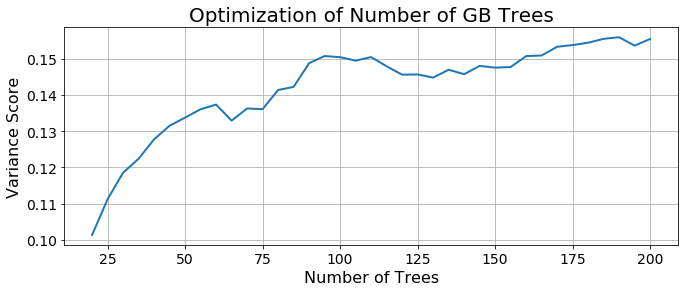

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(score['n_tree'], score['mean_test_score'], linewidth = 2)
ax.set_title('Optimization of Number of GB Trees', fontsize=20)
ax.grid(True)

ax.set_xlabel('Number of Trees', fontsize=16)
ax.set_ylabel('Variance Score', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# plt.savefig('Tree_optimization.png', dpi=600, bbox_inches = "tight")

In [28]:
#Choose all predictors except target & IDcols
# predictors = [x for x in x_train]
param_test1 = {'n_estimators':range(20,501,5)}
treeplot = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                             learning_rate=0.1, 
                                                              min_samples_split=2,
                                                              min_samples_leaf=1,
                                                              max_depth=5,
                                                              max_features='auto',
                                                              subsample=0.9,
                                                              random_state=42), 
param_grid = param_test1,scoring='neg_mean_absolute_error', n_jobs=4,iid=False, cv=5)

treeplot.fit(x_train,y_train)

treeplot.cv_results_, treeplot.best_params_, treeplot.best_score_

({'mean_fit_time': array([ 0.05846872,  0.06617637,  0.06860538,  0.07747078,  0.08641062,
          0.09591208,  0.10978637,  0.12156892,  0.12605352,  0.1323225 ,
          0.14557695,  0.14898343,  0.16218085,  0.17016864,  0.17340269,
          0.1810627 ,  0.19083643,  0.20145612,  0.21211104,  0.22216096,
          0.23590231,  0.2476748 ,  0.25012016,  0.29983373,  0.3753933 ,
          0.34001384,  0.28617587,  0.30438147,  0.36017761,  0.37003298,
          0.33535161,  0.33765936,  0.33939457,  0.34982791,  0.36975422,
          0.38334231,  0.39091091,  0.43622208,  0.38898883,  0.40065408,
          0.40817404,  0.42970181,  0.44639444,  0.4552701 ,  0.51437821,
          0.66355567,  0.67469945,  0.52197943,  0.49173436,  0.53486319,
          0.60510621,  0.58393002,  0.75948315,  0.65078344,  0.78335199,
          0.71733232,  0.58695712,  0.69642119,  0.61236668,  0.69680047,
          0.64413342,  0.7181778 ,  0.69957328,  0.74376526,  0.72802343,
          0.75399065,

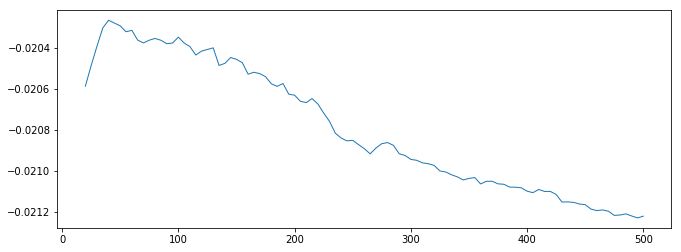

In [31]:
score = pd.DataFrame(treeplot.cv_results_)
score['n_tree'] = range(20,501,5)


fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(score['n_tree'], score['mean_test_score'], linewidth = 1)
# ax.set_title('Non-Tidal Component by FFT - Chesapeake Bay Bridge Tunnel', fontsize=20)
# #ax.set_xlabel('Date', fontsize=16)
# ax.set_ylabel('Water Elevation (m)', fontsize=16)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

### Depth

In [33]:
param_test2 = {'max_depth':range(2,50,1)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                              n_estimators=100, 
                                                              max_features='sqrt', 
                                                              subsample=0.8, 
                                                              random_state=42), 
param_grid = param_test2, n_jobs=4,iid=False, cv=5)

gsearch2.fit(x_train,y_train)

gsearch2.cv_results_, 
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 14}, 0.23956849825819013)

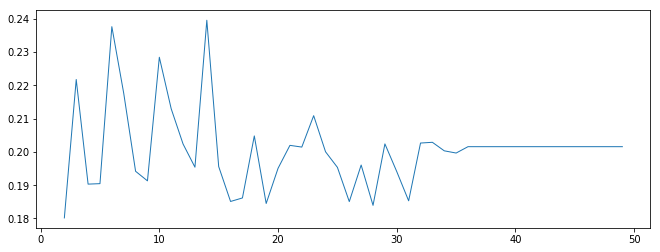

In [34]:
score = pd.DataFrame(gsearch2.cv_results_)
score['depth'] = range(2,50,1)


fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(score['depth'], score['mean_test_score'], linewidth = 1)
# ax.set_title('Non-Tidal Component by FFT - Chesapeake Bay Bridge Tunnel', fontsize=20)
# #ax.set_xlabel('Date', fontsize=16)
# ax.set_ylabel('Water Elevation (m)', fontsize=16)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# Optimization Results

### R_In_No0

In [150]:
# IDEAL1 (SCORE 70%/15%)

gbrt = GradientBoostingRegressor(loss = 'ls',
                                #alpha = .4,
                                learning_rate = 0.05,
                                n_estimators=175,
                                subsample = 0.78,
                                criterion = "friedman_mse",
                                min_samples_split = 2,
                                min_samples_leaf = 11,
                                random_state = 42,
                                max_depth = 6,
                                max_features = 1)
IDEAL1 = gbrt.fit(x_train, y_train)

print(IDEAL1.score(x_test, y_test))
print(IDEAL1.score(x_train, y_train))

0.246201115659
0.687122203147


In [151]:
#IDEAL2 (SCORE 80%/ 16%)

gbrt = GradientBoostingRegressor(loss = 'lad',
                                #alpha = .4,
                                learning_rate = 0.1,
                                n_estimators=500,
                                subsample = 0.9,
                                criterion = "friedman_mse",
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                random_state = 42,
                                max_depth = 5,
                                max_features = 'auto')
IDEAL2 = gbrt.fit(x_train, y_train)

print(IDEAL2.score(x_test, y_test))
print(IDEAL2.score(x_train, y_train))

0.167348352368
0.691848532678


In [152]:
# IDEAL 3 (SCORE 57%/13%)
gbm_tuned_1 = GradientBoostingRegressor(loss = 'lad',
                                        learning_rate=0.05, 
                                        n_estimators=140,
                                        max_depth=12, 
                                        min_samples_split=19, 
                                        min_samples_leaf=9, 
                                        #subsample=0.8, 
                                        random_state=42,
                                        max_features=3)
IDEAL3 = gbm_tuned_1.fit(x_train, y_train)

print(IDEAL3.score(x_test, y_test))
print(IDEAL3.score(x_train, y_train))

0.267752437165
0.577295435731


### R_IND

In [168]:
# Results from optimization, switch up learning rate and see

gbrt = GradientBoostingRegressor(loss = 'lad',
                                learning_rate=0.08,
                                max_depth = 12,
                                max_features=5,
                                min_samples_leaf= 4,
                                min_samples_split=16,
                                n_estimators=95,
                                subsample = 0.8)
                                         

IDEAL4 = gbrt.fit(x_train, y_train)

print(IDEAL4.score(x_test, y_test))
print(IDEAL4.score(x_train, y_train))

0.306043969407
0.637251419789


In [124]:
# tuned_model.fit(x_train, y_train)

### Evaluate

In [169]:
def predict(model, x_train, x_test):   
    pred_test = model.predict(x_test)
    pred_train = model.predict(x_train)
    
    return pred_train, pred_test

In [170]:
pred_train, pred_test = predict(IDEAL4, x_train, x_test)

In [171]:
def variance_score(model, x_train, y_train, x_test, y_test):
    r_train = model.score(x_train, y_train)
    r_test = model.score(x_test, y_test)
    
    return r_train, r_test

In [172]:
r_train, r_test = variance_score(IDEAL4, x_train, y_train, x_test, y_test)

In [173]:
r_test

0.3060439694066962

In [174]:
def evaluate_regression(pred_train, pred_test, y_train, y_test):
    r_train = r2_score(y_train, pred_train)
    print('The training r-squared score is {}'.format(r_train))
    r_test = r2_score(y_test, pred_test)
    print('The testing r-squared score is {}'.format(r_test))
    meanabserrors_train = np.mean(abs(pred_train - y_train))
    print('The training mean absolute error is {}'.format(meanabserrors_train))
    meanabserrors_test = np.mean(abs(pred_test - y_test))
    print('The testing mean absolute error is {}'.format(meanabserrors_test))
    rmse = math.sqrt(mean_squared_error(y_test, pred_test))
    print('The root mean square error is {}'.format(rmse))
    mse = mean_squared_error(y_test, pred_test)
    print('The mean square error is {}'.format(mse))
    errors = pred_test - y_test
    meanerror = np.mean(errors)
    print('The mean error is {}'.format(meanerror))
    return errors

In [175]:
# EXAMPLE
errors = evaluate_regression(pred_train, pred_test, y_train, y_test)

The training r-squared score is 0.6372514197888464
The testing r-squared score is 0.3060439694066962
The training mean absolute error is 0.007986559423763032
The testing mean absolute error is 0.01917788478110185
The root mean square error is 0.02657738265759567
The mean square error is 0.000706357268928267
The mean error is -0.0031348061290996597


In [176]:
def analyze_errors(errors):
    error_range =  max(errors) - min(errors)
    print('The error range is {}'.format(error_range))
    error_max = max(errors)
    print('The error max is {}'.format(error_max))
    error_min = min(errors)
    print('The error min is {}'.format(error_min))

In [177]:
# EXAMPLE
analyze_errors(errors)

The error range is 0.17918024673052846
The error max is 0.0474494755612383
The error min is -0.13173077116929016


In [178]:
def plot_errors(errors):
    plt.hist(errors, 30, histtype='bar', ec='white', color='maroon')
    plt.xlabel('Error')
    plt.ylabel('Count')
    plt.title('Histogram of Model Error')
    plt.grid(True)
    plt.show()

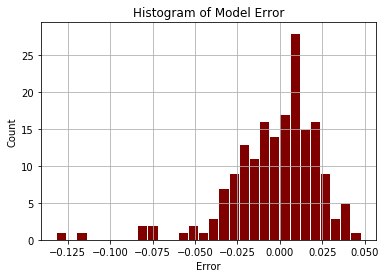

In [179]:
# EXAMPLE
plot_errors(errors)

In [180]:
def plot_predictions(y_test, pred, Title):
    df_predictions = pd.DataFrame(y_test)
    df_predictions['Pred'] = pred
    X = df_predictions.iloc[:, 0].values.reshape(-1, 1)
    Y = df_predictions.iloc[:, 1].values.reshape(-1, 1)
    fig, ax = plt.subplots()
    ax.scatter(X, Y, color='maroon')
    line = mlines.Line2D([0, 1], [0, 1], color='orange')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    ax.set_xlabel(ax.get_xlabel(), fontsize = 18)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)
    plt.xlabel("Damage Index")
    plt.ylabel("Precited Damage Index")
    plt.xlim(0, 0.2)
    plt.ylim(0, 0.2)
    plt.title('Model Evaluation -' +  Title, fontsize = 20)
   # plt.savefig('GB_train_eval.png', dpi=600, bbox_inches = "tight")
    plt.show()

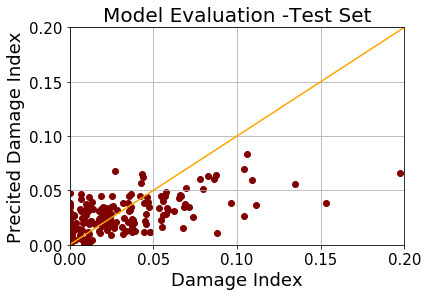

In [181]:
# EXAMPLE
plt.rcParams["figure.figsize"] = (6,4)
Title = 'Test Set'
plot_predictions(y_test, pred_test, Title)

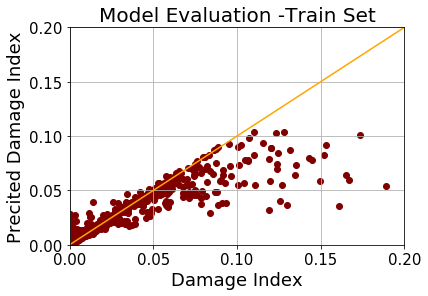

In [182]:
Title = 'Train Set'
plot_predictions(y_train, pred_train, Title)

In [183]:
def plot_joint_predictions(y_train, pred_train, y_test, pred_test, Title):
    df_predictions_test = pd.DataFrame(y_test)
    df_predictions_test['Pred'] = pred_test
    df_predictions_train = pd.DataFrame(y_train)
    df_predictions_train['Pred'] = pred_train   
    X1 = df_predictions_test.iloc[:, 0].values.reshape(-1, 1)
    Y1 = df_predictions_test.iloc[:, 1].values.reshape(-1, 1)
    X2 = df_predictions_train.iloc[:, 0].values.reshape(-1, 1)
    Y2 = df_predictions_train.iloc[:, 1].values.reshape(-1, 1)
    
    fig, ax = plt.subplots()
    ax.scatter(X2, Y2, color='maroon', label='Training Predictions')
    ax.scatter(X1, Y1, color='orange', label='Testing Predictions')
    
    line = mlines.Line2D([0, 1], [0, 1], color='grey')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    ax.set_xlabel(ax.get_xlabel(), fontsize = 18)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)
    plt.xlabel("Damage Index")
    plt.ylabel("Precited Damage Index")
    plt.xlim(0,0.25)
    plt.ylim(0,0.25)
    plt.title('Model Evaluation -' +  Title, fontsize = 20)
    plt.legend(loc='upper left')
    #plt.savefig('test_eval.png', dpi=600, bbox_inches = "tight")
    plt.show()

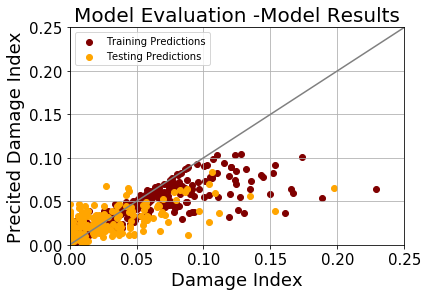

In [184]:
Title = 'Model Results'
plot_joint_predictions(y_train, pred_train, y_test, pred_test, Title)

# Impurity importance

In [185]:
def calc_gini_importances(x_train, model):
    importances = model.feature_importances_
    importances_df = pd.DataFrame(importances, x_train.columns,
                                  columns=['Importance']).sort_values('Importance',
                                  ascending=False)
    importances_df.reset_index(inplace=True)
    importances_df.rename(columns={'index':'Feature'}, inplace=True)
    return importances_df


In [186]:
# indicate if reg_model or class_model
# EXAMPLE
df_gini_importances = calc_gini_importances(x_train, IDEAL3)

In [187]:
def gini_importance_plot(df_gini_importances):
    df_gini_importances.sort_values('Importance', ascending=False).plot.bar('Feature',
                                                                            'Importance', 
                                                                            color='maroon', 
                                                                            legend = False)
    plt.title("Feature Importances", fontsize = 25)
    plt.ylabel('Importance', fontsize = 16)
    plt.xlabel('')
    plt.xticks(fontsize = 16, rotation = 45, ha='right')
    plt.yticks(fontsize = 14)
#     plt.savefig('giniimportance.png', dpi=600, bbox_inches = "tight")
    


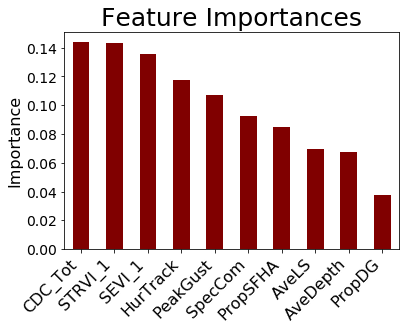

In [188]:
# EXAMPLE
gini_importance_plot(df_gini_importances)

# Permutation Importance

In [200]:
def calc_permutation_imp(model,x,y, features):
    baseline = model.score(x,y)
    imp = []
    for col in x.columns:
        save = x[col].copy()
        x[col]=np.random.permutation(x[col])
        m = model.score(x,y)
        x[col] = save
        imp.append(baseline - m)
        
    Results = np.array(imp)
    Results = pd.DataFrame(Results)
    Results['Feature'] = features
    Results.rename(columns = {0:'Importance'}, inplace=True)
    return Results

In [201]:
features = ['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot'] 
df_perm_imp = calc_permutation_imp(IDEAL3,x_train,y_train, features)

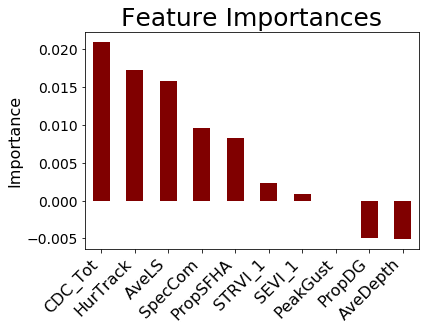

In [202]:
gini_importance_plot(df_perm_imp)

In [206]:
def calc_permutation_imp(model,x,y,features):
    baseline = model.score(x,y)
    imp = []
    features = features
    for col in features:
        save = x.copy()
        x[col]=np.random.permutation(x[col])
        m = model.score(x,y)
        x[col] = save
        imp.append(baseline - m)
    Results = np.array(imp)
    Results = pd.DataFrame(Results)
    Results['Feature'] = features
    Results.rename(columns = {0:'Importance'}, inplace=True)
    return Results

In [207]:
features = ['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot'] 
df_perm_imp = calc_permutation_imp(IDEAL3,x_train,y_train,features)

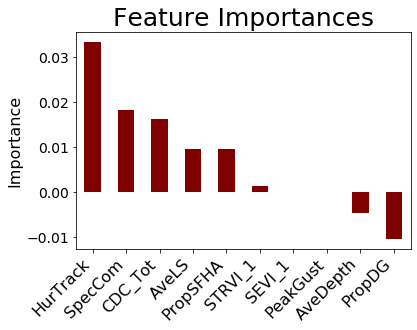

In [208]:
gini_importance_plot(df_perm_imp)

### Group Permutation Importance

In [221]:
x_train.columns

Index(['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot'],
      dtype='object')

In [227]:
features = [['PeakGust', 'HurTrack'],
           ['STRVI_1', 'SpecCom', 'SEVI_1', 'CDC_Tot'],
           ['AveDepth', 'PropDG', 'PropSFHA'],
           ['AveLS']]

In [236]:
I = importances(IDEAL3, x_test, y_test, features=features)

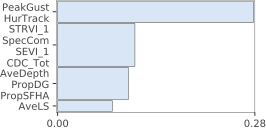

In [237]:
plot_importances(I)

In [238]:
I

,Importance
Feature,
PeakGust\nHurTrack,0.274447
STRVI_1\nSpecCom\nSEVI_1\nCDC_Tot,0.108284
AveDepth\nPropDG\nPropSFHA,0.099076
AveLS,0.076586


In [239]:
I.reset_index(inplace=True)
I.drop(['Feature'], axis=1)
I['Feature'] = ['Wind', 'Vulnerability', 'Flood', 'Landslide']

In [240]:
I

,Feature,Importance
0,Wind,0.274447
1,Vulnerability,0.108284
2,Flood,0.099076
3,Landslide,0.076586


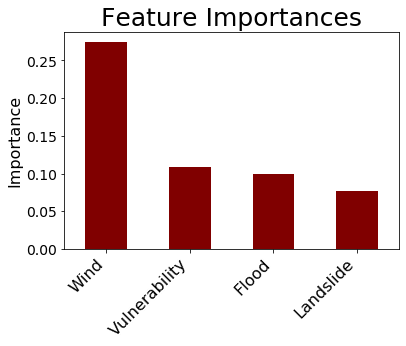

In [242]:
gini_importance_plot(I)

In [ ]:
baseline = IDEAL4.score(x_test, y_test)
imp = []
features = ['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot'] 
for col in features:
    save = x_test.copy()
    x_test[col] = np.random.permutation(x_test[col])
    m = IDEAL4.score(x_test, y_test)
    x_test[col] = save
    imp.append(baseline - m)
test = np.array(imp)

In [132]:
baseline = IDEAL4.score(x_train, y_train)
imp = []
features = ['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot'] 
for col in features:
    save = x_train.copy()
    x_train[col] = np.random.permutation(x_train[col])
    m = IDEAL4.score(x_train, y_train)
    x_train[col] = save
    imp.append(baseline - m)
test =  np.array(imp)

In [129]:
results = pd.DataFrame(test)
results['Feature'] = ['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot'] 
results.rename(columns = {0:'Importance'}, inplace=True)

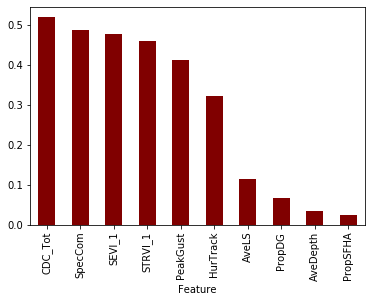

In [130]:
results.sort_values('Importance', ascending=False).plot.bar('Feature', 'Importance', color='maroon', legend = False)

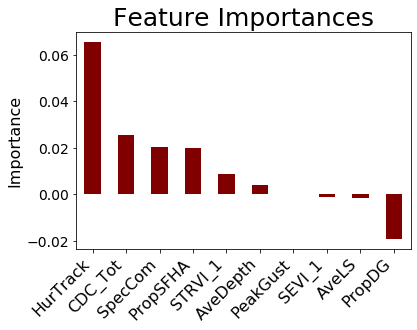

In [127]:
gini_importance_plot(results)

In [88]:
def permutation_importances(est, X_eval, y_eval, metric, features):
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval)
    imp = []
    for col in features:
        save = X_eval[col].copy()
        X_eval[col] = np.random.permutation(X_eval[col])
        m = metric(est, X_eval, y_eval)
        X_eval[col] = save
        imp.append(baseline - m)
    return np.array(imp)

In [96]:
x_train_m = x_train.values
y_train_m = y_train.values

In [97]:
x_train.columns

Index(['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot'],
      dtype='object')

In [98]:
features = ['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot'] 
permutation_importances(IDEAL4, x_train_m, y_train_m, r2_score, features)

TypeError: Expected sequence or array-like, got estimator GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.08, loss='lad', max_depth=12,
                          max_features=5, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=4, min_samples_split=16,
                          min_weight_fraction_leaf=0.0, n_estimators=95,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [153]:
def calc_permutation_importance(criterion, model, df_x, y):
    features = df_x.columns.values
    X = df_x.as_matrix()
    Y = y.as_matrix()
    scores = defaultdict(list)
    rf = model
    for train_idx, test_idx in ShuffleSplit(len(X), 100, .3, random_state=42): #number of splits, absolute number of test samples, proportion of data in train split
        X_train, X_test = X[train_idx], X[test_idx] #Random permutation cross-validator, Yields indices to split data into training and test sets.
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        r = rf.fit(X_train, Y_train)
        acc = criterion(Y_test, rf.predict(X_test))
        for i in range(X.shape[1]): #The shape attribute for numpy arrays returns the dimensions of the array. If Y has n rows and m columns, then Y.shape is (n,m). So Y.shape[0] is n.
            X_t = X_test.copy()
            np.random.seed(42)
            np.random.shuffle(X_t[:, i]) #rearranging randomly
            shuff_acc = criterion(Y_test, rf.predict(X_t)) 
            scores[features[i]].append((acc-shuff_acc)/acc) #change in importance, actual - shuffled/actual, this is percent error        
    mda_features = [f for f in scores.keys()]
    mda_importance = [(np.mean(score)) for score in scores.values()] #average over all the shuffled permutations
    mda_indices = np.argsort(mda_importance)
    return mda_features, mda_importance, mda_indices

In [154]:
#EXAMPLE
#criterion can be r2_score or mean_squared_error
#should be MSE i think

criterion = r2_score
mda_features, mda_importance, mda_indices = calc_permutation_importance(criterion, IDEAL4, x_train, y_train)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


TypeError: 'ShuffleSplit' object is not iterable

In [104]:
# def permutation_importance_plot(mda_features, mda_importance):
#     df_perm_FI = pd.DataFrame({'Feature':mda_features, 'Importance':[abs(number) for number in mda_importance]})
#     df_perm_FI.sort_values('Importance', ascending=False).plot.bar('Feature',
#                                                                    'Importance', 
#                                                                     color='maroon', 
#                                                                     legend = False)
#     plt.title("Feature Importances", fontsize = 30)
#     plt.ylabel('Importance')
#     plt.xlabel('')
#     plt.xticks(fontsize = 12, rotation = 45, ha='right')
#     plt.savefig('permutimportance.png', dpi=600, bbox_inches = "tight")

In [105]:
# # EXAMPLE
# permutation_importance_plot(mda_features, mda_importance)

In [146]:
def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

In [143]:
hi = GradientBoostingRegressor(loss = 'lad',
                                learning_rate=0.08,
                                max_depth = 12,
                                max_features=5,
                                min_samples_leaf= 4,
                                min_samples_split=16,
                                n_estimators=95,
                                subsample = 0.8)

In [144]:
OPT4 = hi.fit(x_train, y_train)

In [145]:
imp = permutation_importances(OPT4, x_train, y_train, oob_regression_r2_score)


AttributeError: 'numpy.ndarray' object has no attribute 'random_state'

In [ ]:
impcopy = imp.copy()

In [87]:
def perm_imp_plot(importances):
    importances.reset_index(inplace=True)
    importances.sort_values('Importance', ascending=False).plot.bar('Feature',
                                                                            'Importance', 
                                                                            color='maroon', 
                                                                            legend = False)
    plt.title("Feature Importances", fontsize = 25)
    plt.ylabel('Importance', fontsize = 16)
    plt.xlabel('')
    plt.xticks(fontsize = 16, rotation = 45, ha='right')
    plt.yticks(fontsize = 14)
#     plt.savefig('giniimportance.png', dpi=600, bbox_inches = "tight")

AttributeError: 'numpy.ndarray' object has no attribute 'random_state'

In [ ]:
perm_imp_plot(imp)

# Partial Dependence

In [67]:
x_train.columns

Index(['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot'],
      dtype='object')

In [70]:
def plot_part_depend(model, x_train, feature_list, feature_names):
    with plt.rc_context({'legend.fontsize': 'large',
              'figure.figsize': (20, 40),
             'axes.labelsize': 'large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'large',
             'ytick.labelsize':'large'}):
        #plt.subplots(nrows=3,ncols=3, sharey=True)
        plot_partial_dependence(model, 
                                x_train, 
                                feature_list, 
                                feature_names = feature_names, 
                                grid_resolution=10, 
                                n_cols=2,
                                method='brute'
                               ) 
        #plt.savefig('partialdependence.png', dpi=400, bbox_inches = "tight")


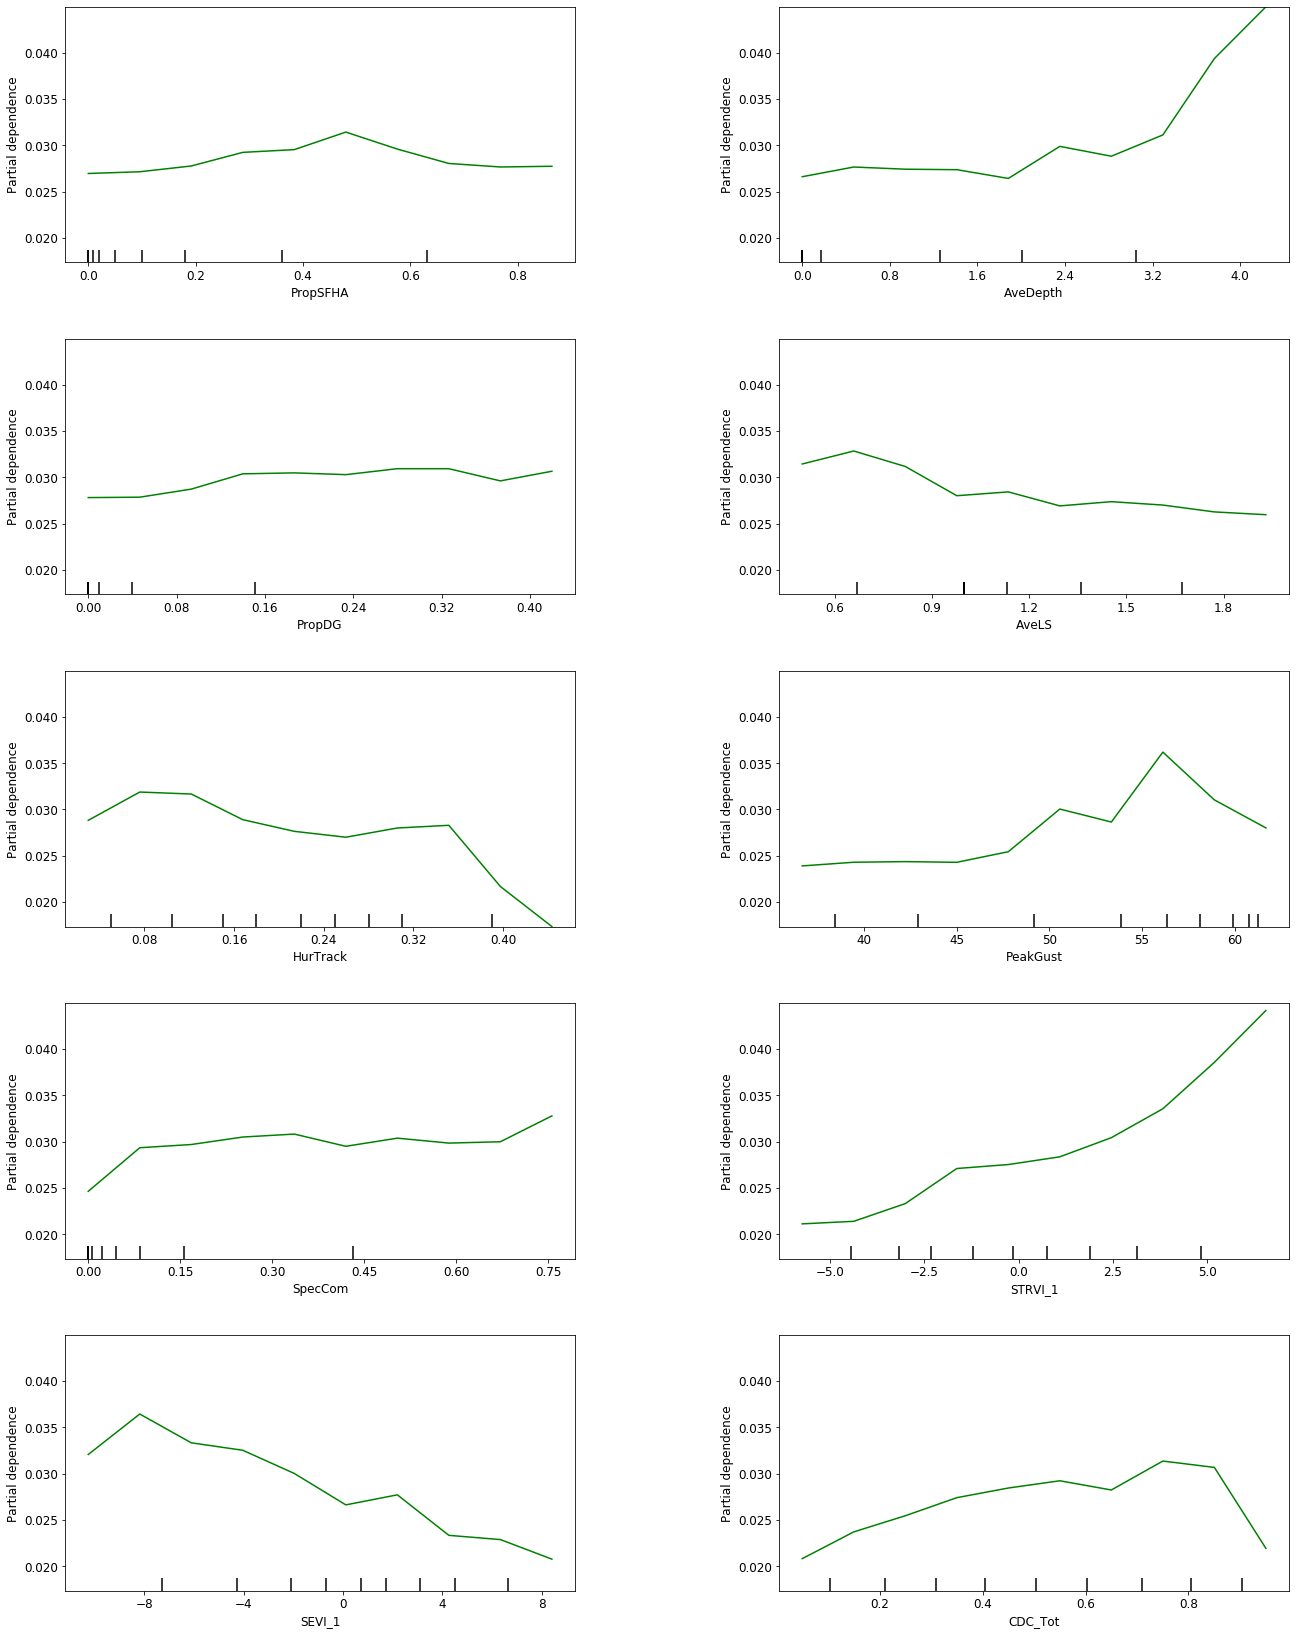

In [72]:
#EXAMPLE
feature_list=[0,1,2,3,4,5,6,7,8,9]
feature_names=['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack',
       'PeakGust', 'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot']
plot_part_depend(IDEAL4, x_train, feature_list, feature_names)

In [73]:
# plt.rcParams["figure.figsize"] = (10,10)
# params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'large',
#          'ytick.labelsize':'large'}
# plt.rcParams.update(params)


# #plt.subplots(nrows=3,ncols=3, sharey=True)
# fig = plot_partial_dependence(IDEAL1, 
#                         x_train, 
#                         [0,1,2,3,4,5,6,7,8,9,10,11,12,13], 
#                         feature_names =['PropSFHA', 'AveDepth', 'PropDG', 'MaxDepth', 'AveLS', 'HurTrack',
#                            'PeakGust', 'MaxSusta', 'SpecCom', 'STRVI_1', 'SEVI_1', 'STR_SEVI_1',
#                            'SOVI_1', 'CDC_Tot'], 
#                         grid_resolution=10, 
#                         #n_cols=2
#                        ) 

# plt.tight_layout(h_pad=3,w_pad=1)

# plt.savefig('partialdependence.png', dpi=400, bbox_inches = "tight")



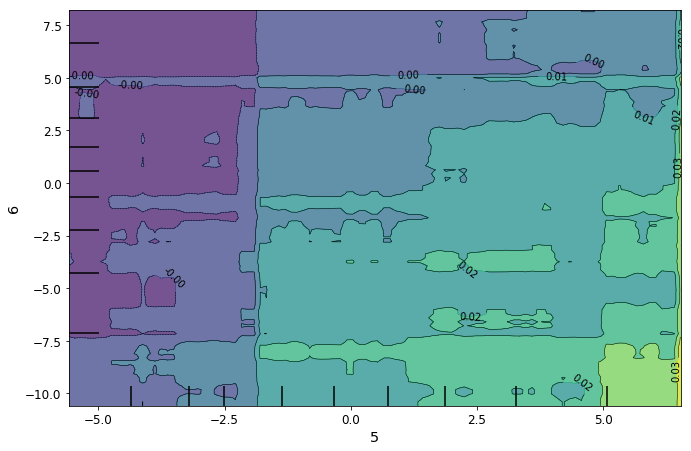

In [90]:
fig = plot_partial_dependence(IDEAL2, x_train, [(5,6)]) 

In [29]:
from pycebox.ice import ice, ice_plot

In [31]:
forty_ice_df = ice(data=x_train, column='HurTrack', 
                   predict=IDEAL2.predict)

In [33]:
cmap2 = plt.get_cmap('OrRd')

In [44]:
wt_vals = forty_ice_df.columns.get_level_values('PeakGust').values
sm = plt.cm.ScalarMappable(cmap=cmap2, 
                           norm=plt.Normalize(vmin=wt_vals.min(), 
                                              vmax=wt_vals.max()))
sm._A = []

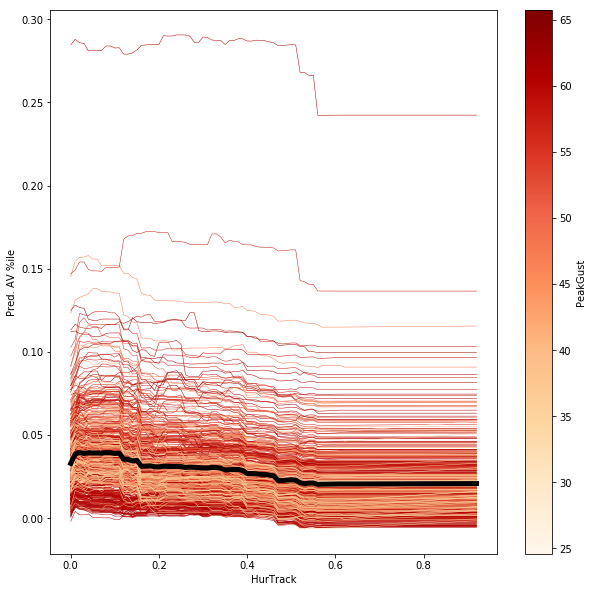

In [47]:
ice_plot(forty_ice_df, linewidth=.5, color_by='PeakGust', cmap=cmap2, plot_pdp=True, 
         pdp_kwargs={'c': 'k', 'linewidth': 5})
plt.colorbar(sm, label='PeakGust')
plt.ylabel('Pred. AV %ile')
plt.xlabel('HurTrack');